In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
# Load and preprocess data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set batch size
batch_size = 32

train_generator = train_datagen.flow_from_directory('split_data/train', target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory('split_data/val', target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory('split_data/test', target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

def create_resnet_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Initialize and compile the model
resnet_model = create_resnet_model()
resnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_resnet = resnet_model.fit(train_generator, epochs=50, validation_data=val_generator)

# Save the model
resnet_model.save('resnet_model.h5')


Found 7003 images belonging to 6 classes.
Found 2001 images belonging to 6 classes.
Found 1001 images belonging to 6 classes.
Epoch 1/50
219/219 [==============================] - 1277s 6s/step - loss: 1.2959 - accuracy: 0.5145 - val_loss: 6.9996 - val_accuracy: 0.1679
Epoch 2/50
219/219 [==============================] - 1265s 6s/step - loss: 0.9079 - accuracy: 0.6617 - val_loss: 1.9336 - val_accuracy: 0.1689
Epoch 3/50
219/219 [==============================] - 1276s 6s/step - loss: 0.7493 - accuracy: 0.7274 - val_loss: 3.1567 - val_accuracy: 0.1684
Epoch 4/50
219/219 [==============================] - 1284s 6s/step - loss: 0.6657 - accuracy: 0.7587 - val_loss: 1.4193 - val_accuracy: 0.4213
Epoch 5/50
219/219 [==============================] - 1292s 6s/step - loss: 0.5842 - accuracy: 0.7864 - val_loss: 2.7757 - val_accuracy: 0.3553
Epoch 6/50
219/219 [==============================] - 1297s 6s/step - loss: 0.5170 - accuracy: 0.8152 - val_loss: 1.0294 - val_accuracy: 0.6472
Epoch 7/50

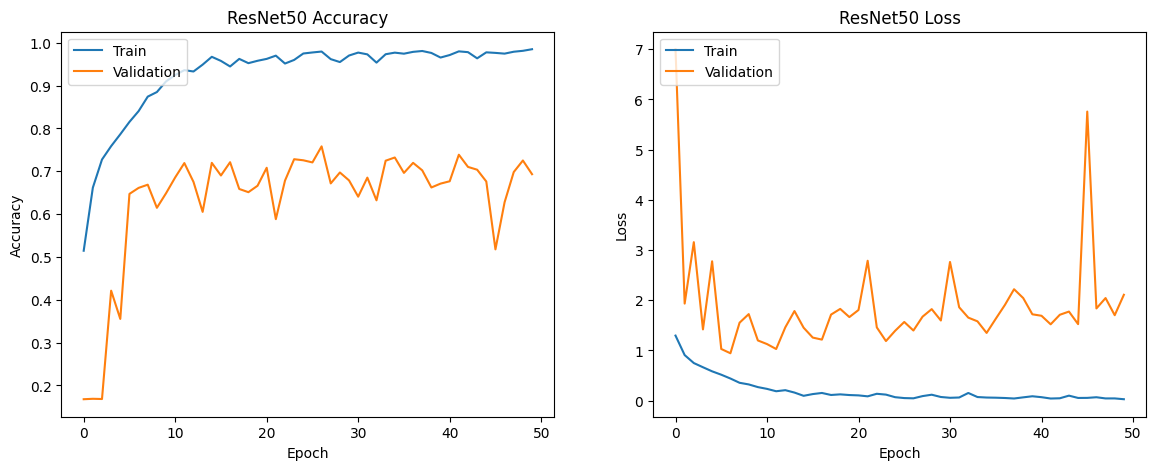

In [3]:

def plot_performance(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

    # Plot performance for ResNet50
plot_performance(history_resnet, 'ResNet50')

In [4]:
# Compute mAP
y_true = test_generator.classes
y_pred_probs = resnet_model.predict(test_generator)

precision = dict()
recall = dict()
average_precision = dict()
n_classes = train_generator.num_classes

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred_probs[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_pred_probs[:, i])

# Compute Mean Average Precision (mAP)
mean_average_precision = np.mean(list(average_precision.values()))
print(f'Mean Average Precision (mAP): {mean_average_precision}')


32/32 [==============================] - 42s 1s/step
Mean Average Precision (mAP): 0.1760252000273008


219/219 [==============================] - 282s 1s/step


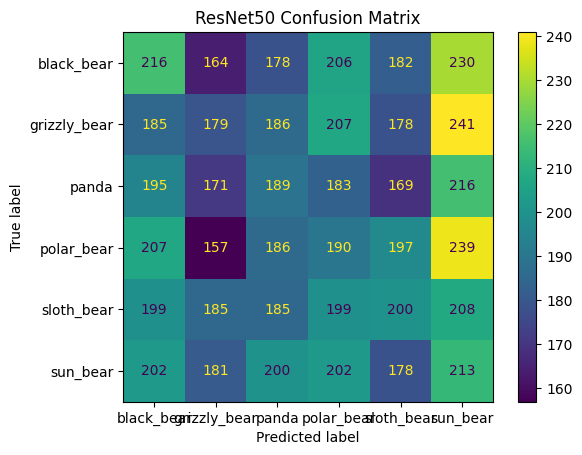

In [5]:
def plot_confusion_matrix(model, generator, model_name):
    Y_pred = model.predict(generator)
    y_pred = np.argmax(Y_pred, axis=1)
    cm = confusion_matrix(generator.classes, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=generator.class_indices.keys()).plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

plot_confusion_matrix(resnet_model, train_generator, 'ResNet50')



In [6]:
train_loss, train_accuracy = resnet_model.evaluate(train_generator)
print(f'loss: {train_loss}, acc: {train_accuracy}')

219/219 [==============================] - 284s 1s/step - loss: 0.1351 - accuracy: 0.9563
loss: 0.1351090520620346, acc: 0.9563044309616089


In [7]:
val_loss, val_accuracy = resnet_model.evaluate(val_generator)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy}')

63/63 [==============================] - 80s 1s/step - loss: 2.1088 - accuracy: 0.6932
Validation loss: 2.108752489089966, Validation accuracy: 0.693153440952301


In [8]:
test_loss, test_accuracy = resnet_model.evaluate(test_generator)
print(f'loss: {test_loss}, acc: {test_accuracy}')

32/32 [==============================] - 40s 1s/step - loss: 1.9565 - accuracy: 0.7033
loss: 1.9565093517303467, acc: 0.7032967209815979
